<h1> Finding a good de-noised image</h1>

<h3> Some properties of the full image</h3>

In [1]:
from utils.global_props import get_all_letters
background_x = 1200
background_y = 1200

alphabet_size = len(get_all_letters())

In [2]:
from PIL import Image
def load_base_image(letter):
    img = Image.open(f"base_images/{letter}.jpeg")
    return img


In [3]:
def make_de_noised_image(image:str, save_file_name="", verbose=False):
    all_letters = sorted(list(image))
    # Load images per letter
    all_letters_images = [load_base_image(l) for l in all_letters] 
    
    #Space between letters and border
    offset = 10
    new_letter_size = (background_x-offset*(alphabet_size+1))//alphabet_size
    # Resize the letter to fit the larger image
    all_letters_images = [image.resize([new_letter_size,new_letter_size]) for image in all_letters_images]
    
    background = Image.new('RGB',(background_x,background_y))

    x_offset_total = int(background_x // 2 - offset*1/2*(len(image)-1) - len(image)*new_letter_size/2)
    x_offset_each = offset + new_letter_size
    y_offset = int(background_y // 2 - new_letter_size // 2)
    
    curr_x = x_offset_total
    for letter_img in all_letters_images:
        background.paste(letter_img, [curr_x, y_offset])
        curr_x += x_offset_each
    if verbose:
        background.show()
    
    if save_file_name != "":
        background.save(f"base_images/simple_images/{save_file_name}.png")
    return background


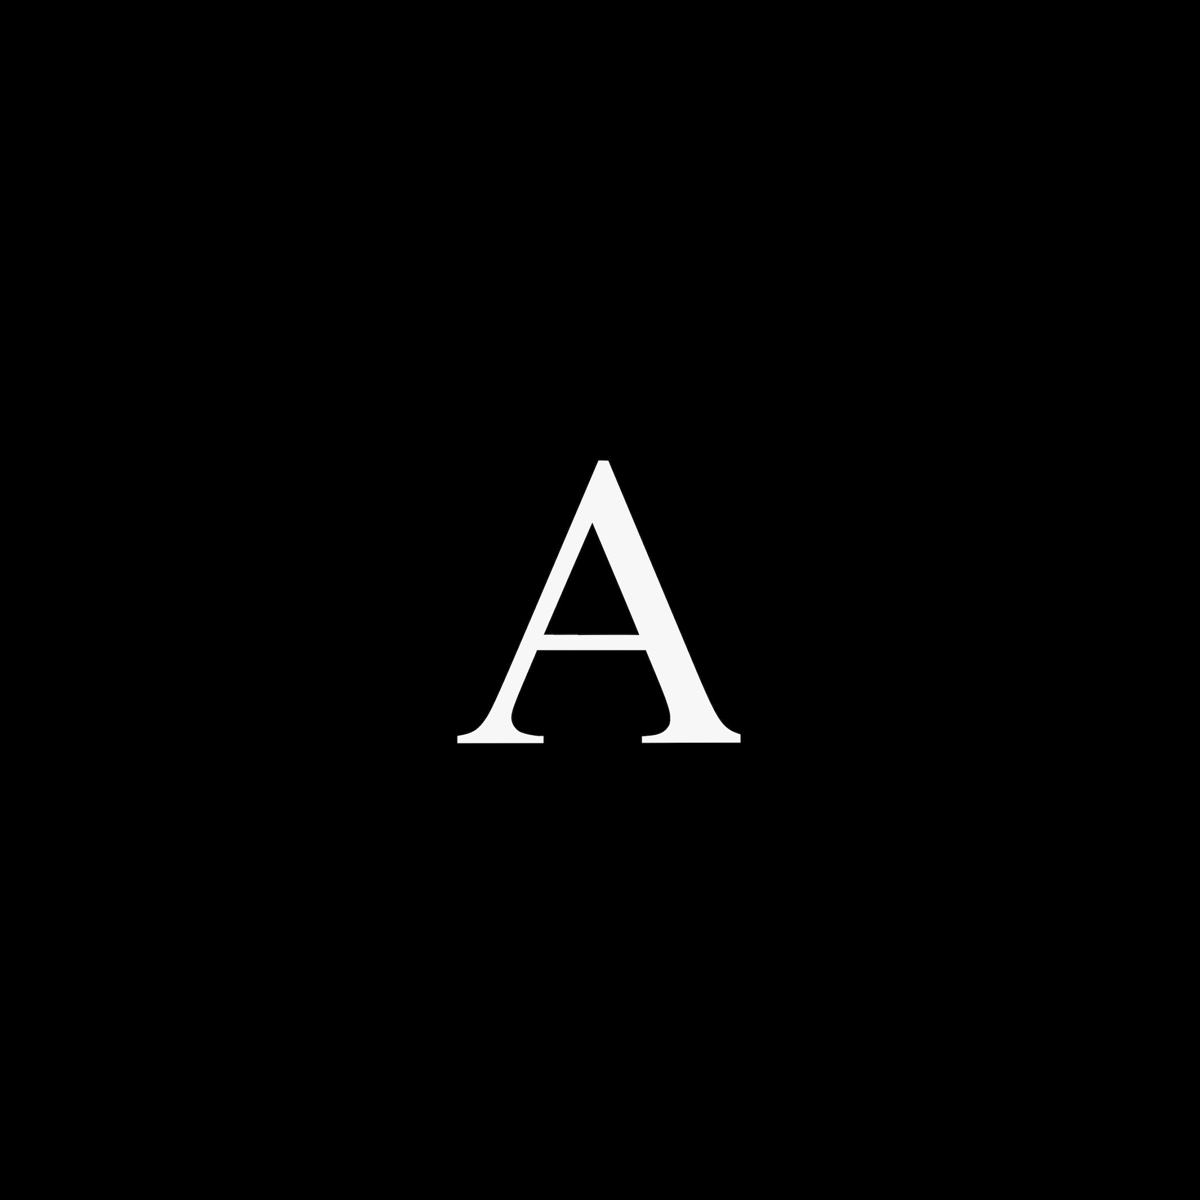

In [4]:
make_de_noised_image("A")

<h2> The above code can convert one image to a simplified version </h2>

In [5]:
from PIL import Image
def load_question_template():
    img = Image.open("base_images/base_question/question_template.png")    
    return img


In [6]:
def place_images_in_boxes(positive_images, negative_images):
    base = load_question_template()
    positive_top_left = [170,1770]
    positive_bottom_right = [2690,7350]
    
    negative_top_left = [2975,1770]
    negative_bottom_right = [5495,7350]
    
    # Size of lettergroup images
    w_l = 0
    h_l = 0
    if len(positive_images) > 0:
        w_l,h_l = positive_images[0].size
    elif len(negative_images) > 0:
        w_l,h_l = negative_images[0].size
    else:
        return base
    
    # Find offset such that space between images and edges are same
    
    # with of rectangle positive box
    X_b = positive_bottom_right[0] - positive_top_left[0]
    
    off_set = (X_b - 2*w_l)//3
    
        
    # positive examples
    curr_x = positive_top_left[0] + off_set
    curr_y = positive_top_left[1] + off_set
    for i,image in enumerate(positive_images):
        base.paste(image, [curr_x, curr_y])
        
        w,h = image.size
        if i % 2==0:
            curr_x = curr_x + w + off_set
        else:
            curr_x = positive_top_left[0] + off_set
            curr_y = curr_y + h + off_set
        
    # negative examples
    curr_x = negative_top_left[0] + off_set
    curr_y = negative_top_left[1] + off_set
    for i,image in enumerate(negative_images):
        base.paste(image, [curr_x, curr_y])
        #base.show()
        
        w,h = image.size
        if i % 2==0:
            curr_x = curr_x + w + off_set
        else:
            curr_x = negative_top_left[0] + off_set
            curr_y = curr_y + h + off_set
    
    return base

In [7]:
from human_experiments.find_teachingset import get_images_matching_teaching_set as get_images
def generate_question_from_ts(teaching_set,ai,filename,noise=True,seed=420):
    if noise:
        positive_images = get_images([(l,v) for l,v in teaching_set if v],ai,seed=seed)
        negative_images = get_images([(l,v) for l,v in teaching_set if not v],ai,seed=seed)
    else:
        positive_images = [make_de_noised_image(l) for l,v in teaching_set if v]
        negative_images = [make_de_noised_image(l) for l,v in teaching_set if not v]
    
    # resize images
    positive_images = [img.resize([background_x,background_y]) for img in positive_images]
    negative_images = [img.resize([background_x,background_y]) for img in negative_images]

    question = place_images_in_boxes(positive_images,negative_images)
    question.save(f"human_experiments/teaching_sets/{filename}")
    return question
    


In [8]:
def res_converter(result:str):
    labels,values = result.split(",")
    labels = labels.split("-")
    values = values.split("-")
    ts = []
    for label,value in zip(labels,values):
        ts.append((label,value=="1"))
    return ts

In [9]:
ts = res_converter("A-AB-ABCD-ABD-AC-ACD-AD-B-BC-BCD,1-0-0-1-0-1-0-1-0-1")

In [10]:
from models.trainModel import load_model
ai = load_model(f"Phi_v2_6_random")
generate_question_from_ts(ts,ai,filename="test.png",noise=True)

2023-02-21 15:36:02.664820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-21 15:36:02.664909: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2
label:  A
label:  ABD
label:  ACD
label:  B
label:  BCD
label:  AB
label:  ABCD
label:  AC
label:  AD
label:  BC


In [11]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
from PIL import Image, ImageDraw, ImageFont
def get_size_of_text(text,font):
    left, top, right, bottom= (font.getbbox(text))
    w = right-left
    h = bottom - top
    return w,h
def add_test_examples(images, background=None,filename="questions.png"):
    base = background
    if base is None:
        base = load_question_template()

    full_x,full_y = base.size
    end_negative_box = 5517
    rest_x = full_x-end_negative_box
    
    # We calulate the offset in the y-direction
    num_img_on_page = full_y //  background_y
    tot_rest = full_y-background_y*num_img_on_page
    offset_y = tot_rest // (num_img_on_page+1)
    
    # find x offset such that there is equal space between edges and between image and text
    myFont = ImageFont.truetype("/Users/brigt/Library/Fonts/Enigmatic_Bold.ttf",size=300) #TODO: This shoud be in project, not local
    text = f"Image {1}"
    text_w,text_h = get_size_of_text(text,myFont)
    offset_x = (rest_x - background_x - text_w)/3
    
    # start x for image
    x_relative = offset_x  
    x_img_start = x_relative + end_negative_box # end of negative box
    # start values for y
    y_start = offset_y + offset_y + background_y
    curr_y = y_start   
    
    for image in images:
        if curr_y + background_y > full_y:
            print(f"{bcolors.WARNING}ERROR! Too many images, could past them all!{bcolors.ENDC}")
            break
        base.paste(image, [int(x_img_start), curr_y])
        curr_y = curr_y + offset_y + background_y
        
    # Add 2D graphics in an image
    draw = ImageDraw.Draw(base)
        
    # We find the x start of the image. There is two offsets and a image before the text starts
    x_pos = offset_x*2 + background_x + end_negative_box
    curr_y = y_start #we line the text up with the image. So start with same off_set
    
    for i,image in enumerate(images):
        if curr_y + background_y > full_y:
            print(f"{bcolors.WARNING}ERROR! Too many images, could past them all!{bcolors.ENDC}")
            break
        text = f"Image {i+1}"
        w,h = get_size_of_text(text,myFont)
        y_pos = int(curr_y + background_y/2 - h/2) # Find the middle of the image, and then center text at this point
        draw.text((x_pos, y_pos), text, font=myFont, fill =(0, 0, 0))

        curr_y = curr_y + offset_y + background_y # Find start of next image.
        
    base.save(f"human_experiments/questions/{filename}")
    return base
        
    
    
    
    

In [12]:
add_test_examples(list(map(make_de_noised_image,["AB","CD","A","AB","BD"])))

In [54]:
from utils.common import get_all_letter_combinations,one_hot_to_number,remove_digit_from_labels
from utils.dataset import load_dataset
import random 
from PIL import Image


def generate_simulatability_set(k,ai,ts_union,ts_intersection,seed=420):
    print("union:", str(ts_union), "intersection: ", str(ts_intersection))
    rnd = random.Random(seed)
    X,Y,labels = load_dataset()  
    instance_letter_combo = list(zip(X,labels))
    
    img_to_show = []
    ai_values = []
    letters = []
    
    # Add one test example from the ts
    """
    while len(letters) < 1:
        x,l = rnd.choice(instance_letter_combo)
        l = "".join(remove_digit_from_labels(l))
        if l in ts_letters:
            letters.append(l)
            img_to_show.append(Image.fromarray(x).resize([background_x,background_y]))
            ai_values.append(one_hot_to_number(ai.predict(x)))
        
    """

    all_lg = get_all_letter_combinations()
    for l in ts_union:
        all_lg.remove(l)
    
    rnd = random.Random(seed)
    while len(letters) < k:
        print("non_union: ", str(all_lg))
        print("intersection: ", str(ts_intersection))
        l = ""
        if len(all_lg) >= 1:
            l = rnd.choice(all_lg)
            all_lg.remove(l)
        else:
            l = rnd.choice(ts_intersection)
            ts_intersection.remove(l)
            
        letters.append(l)
    
    for curr_l in letters:
        rnd = random.Random(seed)
        instance_letter_combo = list(zip(X,labels))
        rnd.shuffle(instance_letter_combo)
        for x,l in instance_letter_combo:
            if curr_l == "".join(remove_digit_from_labels(l)):
                img_to_show.append(Image.fromarray(x).resize([background_x,background_y]))
                ai_values.append(one_hot_to_number(ai.predict(x)))
                break
            

       
    for i in range(len(img_to_show)):
        print(letters[i], ai_values[i])
        #img_to_show[i].show()
    return img_to_show

In [55]:
def create_full_question(bool_ts,ai,ts_noise=True,sim_letters=None,nr_test_images=5, filename="questions.png",sim_seed=420,ts_seed=420,ts_union=[],ts_intersection=[]):
    # Convert TS to img with TS
    ts_img = generate_question_from_ts(ts,ai,filename=filename,noise=ts_noise,seed=ts_seed)
    
    # Generate simulatability test examples
    sim_img = None
    if sim_letters is not None:
        pass
    else:
        if ts_union == []:
            ts_union = [l for l,v in bool_ts]
        print(sim_seed)
        sim_img = generate_simulatability_set(nr_test_images,ai,ts_union=ts_union,ts_intersection=ts_intersection,seed=sim_seed)
    
    full_q = add_test_examples(sim_img, background=ts_img,filename=filename)
    return full_q

In [66]:
smart_ts = res_converter("-D,1-0")
random_ts = res_converter("-BD,1-0")
teaching_sets = [smart_ts, random_ts]

for i,ts in enumerate(teaching_sets):
    ts_union = set()
    smart_lgs = [ts_union.add(l) for l,v in smart_ts]
    random_lgs = [ts_union.add(l) for l,v in random_ts]
    ts_union = sorted(list(ts_union))

    ts_intersection = []
    for l,v in smart_ts:
        if l in [l for l,v in random_ts]:
            ts_intersection.append(l)

    if len(set_of_all_lg) == 16:
        print("All lg are used")
    print(set_of_all_lg)

    # Load AI (to know evaluation of test examples)
    from models.trainModel import load_model
    name = "Phi_v2_5_nD"
    ai = load_model(name)

    if "CNN_paper_work_" in name:
        name = name[len("CNN_paper_work_"):]
    # Should TS nave noise?
    ts_noise = True


    # Create TS   

    # CHANGE THE WAY WE SELECT SIM_EXAMPLES TO EXCLUDE LETTER GROUPS IN THE TS (One in, rest out, random)
    # Seed for noise TS and sim images
    seed_ts = 0 + int(name.lower().replace("_",""),36)
    seed_sim = 0 + int(name.lower().replace("_",""),36)
    print(seed_sim)
    filename = f"{name}{'_smart' if i == 0 else '_random'}.png"

    create_full_question(ts,ai,filename=filename,ts_noise=ts_noise, ts_seed=seed_ts,sim_seed=seed_sim,ts_union=ts_union,ts_intersection=ts_intersection)

['', 'A', 'AB', 'ABCD', 'ABD', 'AC', 'ACD', 'AD', 'B', 'BC', 'BCD', 'CD', 'D']
1997249962009
label:  
label:  D
1997249962009
union: ['', 'BD', 'D'] intersection:  ['']
non_union:  ['A', 'B', 'C', 'AB', 'AC', 'AD', 'BC', 'CD', 'ABC', 'ABD', 'ACD', 'BCD', 'ABCD']
intersection:  ['']
non_union:  ['A', 'B', 'C', 'AB', 'AD', 'BC', 'CD', 'ABC', 'ABD', 'ACD', 'BCD', 'ABCD']
intersection:  ['']
non_union:  ['A', 'B', 'C', 'AB', 'AD', 'BC', 'ABC', 'ABD', 'ACD', 'BCD', 'ABCD']
intersection:  ['']
non_union:  ['B', 'C', 'AB', 'AD', 'BC', 'ABC', 'ABD', 'ACD', 'BCD', 'ABCD']
intersection:  ['']
non_union:  ['B', 'C', 'AB', 'AD', 'BC', 'ABD', 'ACD', 'BCD', 'ABCD']
intersection:  ['']
AC 1
CD 0
A 1
ABC 1
BC 1
['', 'A', 'AB', 'ABCD', 'ABD', 'AC', 'ACD', 'AD', 'B', 'BC', 'BCD', 'CD', 'D']
1997249962009
label:  
label:  BD
1997249962009
union: ['', 'BD', 'D'] intersection:  ['']
non_union:  ['A', 'B', 'C', 'AB', 'AC', 'AD', 'BC', 'CD', 'ABC', 'ABD', 'ACD', 'BCD', 'ABCD']
intersection:  ['']
non_union: 

In [26]:
# Convert TS to img with TS
img = Image.open("/Users/brigt/Desktop/Toy_quest.png")
# Generate simulatability test examples
sim_img = [Image.open("/Users/brigt/Downloads/Tractor.png").resize([background_x,background_y])]


full_q = add_test_examples(sim_img, background=img,filename="Tractor_question.png")
full_q